In [ ]:
#Importa ll the necessary libraries.
import statistics as sta
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
warnings.filterwarnings('ignore')

### Reading the necessary data.

In [ ]:
#reading the total exports of commodities file.
egc = pd.read_csv("C:/Users/pedro/Documents/GitHub/IronPoppyNevinAdley/exports.csv")
egc

In [ ]:
#rename the year column.
egc = egc.rename(columns={'Unnamed: 0':'year'})
egc

In [ ]:
#reading the Cerrado deforestation file.
dgc = pd.read_csv("C:/Users/pedro/Documents/GitHub/IronPoppyNevinAdley/deforestation_cerrado_t.csv")
dgc

In [ ]:
#Drop column.
dgc = dgc.drop(['Unnamed: 0'], axis = 1)
dgc

### Merge

In [ ]:
#merge the exportation with deforestation.
gc = egc.merge(dgc,on='year')
gc

In [ ]:
#drop the initial years to help make the data stationary.
gc = gc.drop(gc.index[[0, 1, 2, 3]])
gc

In [ ]:
#Standardize the names.
gc.rename(columns={'Deforestation Cerrado':'Total Cerrado Deforestation'}, inplace=True)

In [ ]:
#create a new file out of the new table.
gc.to_csv('FinalFinalgc.csv')

In [ ]:
#make the years as index
gc = pd.read_csv("FinalFinalgc.csv", index_col = 'year') 
gc

In [ ]:
#drop unnecessary column
gc = gc.drop(['Unnamed: 0'], axis=1)
gc

In [ ]:
#use Logarithm transformation to push the data to be stationary and work with different unit measures.
gc = np.log(gc)
gc

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(20,15))
for i, ax in enumerate(axes.flatten()):
    data = gc[gc.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(gc.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout();

### Granger Causality

In [ ]:
#Cross correlation between variables and deforestation, for one to three lags.
def cross_correlation(X,Y,lag):
    return X.corr(Y.shift(lag))
[{j,l,cross_correlation(gc[f'{j}'],gc['Total Cerrado Deforestation'],l)} for l in range(3) for j in list(gc.columns)[:-1]]

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=4, dpi=120, figsize=(15,12))
for i, ax in enumerate(axes.flatten()):
    data = gc[gc.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(gc.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#Check Granger Causality of all possible combinations of the Time series.
#The rows are the response variable, columns are predictors. The values in the table 
#are the P-Values. P-Values lesser than the significance level (0.05), implies 
#the Null Hypothesis that the coefficients of the corresponding past values is 
#zero, that is, the X does not cause Y can be rejected.

#data      : pandas dataframe containing the time series variables
#variables : list containing names of the time series variables.

    gc = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in gc.columns:
        for r in gc.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            gc.loc[r, c] = min_p_value
    gc.columns = [var + '_x' for var in variables]
    gc.index = [var + '_y' for var in variables]
    return gc

grangers_causation_matrix(gc, variables = gc.columns)    

In [ ]:
#rubber failed the granger causality.
gc = gc.drop(['Total rubber exports', ], axis=1)

In [ ]:
#checking the cointegration between variables.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(gc, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(gc,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(gc.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(gc)



In [ ]:
#Defining the train and test set.
nobs = 2
gc_train, gc_test = gc[0:-nobs], gc[-nobs:]

#Check size
print(gc_train.shape)  # (119, 8)
print(gc_test.shape)  # (4, 8)

In [ ]:
#Use the Augumented Dickey-Fuller test to check if the time series are stationary.
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [ ]:
#ADF Test on each column
for name, column in gc_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
#1st difference
gc_differenced = gc_train.diff().dropna()

In [ ]:
#ADF Test on each column of 1st Differences Dataframe
for name, column in gc_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
#Second difference.
gc_differenced = gc_differenced.diff().dropna()

In [ ]:
#ADF Test on each column of second Differences Dataframe
for name, column in gc_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
gc_differenced

In [ ]:
#training the model with different lags. At lag 1 the array is not positive definite.
model = VAR(gc_differenced)
for i in [2, 3, 4, 5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

In [ ]:
#Train the VAR model with lags 4.
model_fitted = model.fit(3)
model_fitted.summary()

In [ ]:
#Use the Durbin Watson to check the Autocorrelation of the residuals of the time series.It made me change the Lags to 4.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(gc_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

In [ ]:
#Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #

#Input data for forecasting
forecast_input = gc_differenced.values[-lag_order:]
forecast_input

In [ ]:
#Forecast the next two years and print them.
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
gc_forecast = pd.DataFrame(fc, index=gc.index[-nobs:], columns=gc.columns + '_2d')
gc_forecast

In [ ]:
#Reverting the two differences.
def invert_transformation(gc_train, gc_forecast, second_diff=True):
    """Revert back the differencing to get the forecast to original scale."""
    gc_fc = gc_forecast.copy()
    columns = gc_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            gc_fc[str(col)+'_1d'] = (gc_train[col].iloc[-1]-gc_train[col].iloc[-2]) + gc_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        gc_fc[str(col)+'_forecast'] = gc_train[col].iloc[-1] + gc_fc[str(col)+'_1d'].cumsum()
    return gc_fc

In [ ]:
#getting the forecasting result.
gc_results = invert_transformation(gc_train, gc_forecast)        
gc_results.loc[:, ['Total cattle and meat exports_forecast', 'Total wood exports_forecast', 'Total soy exports_forecast', 'Total coffee exports_forecast', 'Total Cerrado Deforestation_forecast']]

In [ ]:
gc

In [ ]:
#Comparing in a chart the forecast result with the actual value 
fig, axes = plt.subplots(nrows=int(len(gc.columns)/2), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(gc.columns, axes.flatten())):
    gc_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    gc_test[col][-nobs:].plot(legend=True, ax=ax, kind='line');
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#Checking the accurace of the model.
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Total cattle and meat exports')
accuracy_prod = forecast_accuracy(gc_results['Total cattle and meat exports_forecast'].to_numpy(), gc_test['Total cattle and meat exports'].to_numpy())
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Total wood exports')
accuracy_prod = forecast_accuracy(gc_results['Total wood exports_forecast'].to_numpy(), gc_test['Total wood exports'].to_numpy())
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Total soy exports')
accuracy_prod = forecast_accuracy(gc_results['Total soy exports_forecast'].to_numpy(), gc_test['Total soy exports'].to_numpy())
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: Total Cerrado Deforestation')
accuracy_prod = forecast_accuracy(gc_results['Total Cerrado Deforestation_forecast'].to_numpy(), gc_test['Total Cerrado Deforestation'].to_numpy())
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

### Forecasting the future

In [ ]:
#Bringing in the original values

In [ ]:
#making the differencing of the whole table.
gc_all_diff = gc.diff().dropna()

In [ ]:
#second differencing.
gc_all_diff = gc_all_diff.diff().dropna()
gc_all_diff

In [ ]:
#gettig the last year
model_fitted = model.fit(1)
model = VAR(gc_all_diff)
lag_order = model_fitted.k_ar

#Input data for forecasting
forecast_input_all = gc_all_diff.values[-lag_order:]
forecast_input_all

In [ ]:
#make the prediction for the next three years
prediction = model_fitted.forecast(y=forecast_input_all, steps=3)

In [ ]:
#Checking the results.
prediction = pd.DataFrame(prediction, columns=gc_all_diff.columns + '_2d')
prediction = prediction.rename(index={0:2023, 1:2024, 2:2025})
prediction

In [ ]:
#Reversing the differencing.
gc_predicted = invert_transformation(gc, prediction) 
gc_predicted = gc_predicted.loc[:, ['Total cattle and meat exports_forecast', 'Total wood exports_forecast', 'Total soy exports_forecast','Total coffee exports_forecast', 'Total Cerrado Deforestation_forecast']]
gc_predicted

In [ ]:
#standardizing the column names.
gc_predicted = gc_predicted.rename(columns={'Total cattle and meat exports_forecast':'Total cattle and meat exports', 'Total wood exports_forecast': 'Total wood exports', 'Total soy exports_forecast':'Total soy exports','Total coffee exports_forecast':'Total coffee exports', 'Total Cerrado Deforestation_forecast':'Total Cerrado Deforestation'})

In [ ]:
gc_predicted

In [ ]:
#Reversing the Log from the prediction.
gc_predicted = np.exp(gc_predicted)

In [ ]:
#Reversing the Log from the DataFrame.
gc_all_new = np.exp(gc)

In [58]:
gc_all_new = gc_all_new.drop(columns='Total cocoa exports')

In [59]:
#Concatenating prediction and table.
final = pd.concat([gc_all_new, gc_predicted], axis=0)

In [60]:
final

,Total cattle and meat exports,Total wood exports,Total soy exports,Total coffee exports,Total Cerrado Deforestation
2005,3.472239e+08,1.510530e+09,1.057810e+10,8.053419e+08,16763.469800
2006,4.021849e+08,1.485338e+09,1.023524e+10,8.820798e+08,16763.469800
2007,2.989044e+08,1.703562e+09,9.566551e+09,8.852683e+08,13236.536323
2008,1.312445e+08,1.289001e+09,8.905837e+09,9.608392e+08,13236.536323
2009,1.418567e+08,7.933405e+08,8.209373e+09,9.240666e+08,9854.539473
2010,1.576769e+08,8.392297e+08,5.382201e+09,9.832631e+08,9854.539473
2011,1.496994e+08,6.883544e+08,5.039373e+09,9.377824e+08,8975.341458
2012,1.655764e+08,5.386584e+08,4.905662e+09,7.948685e+08,8975.341458
2013,2.048152e+08,6.024996e+08,4.712690e+09,8.894710e+08,13311.985692
2014,1.685335e+08,7.284682e+08,5.840593e+09,1.054021e+09,10713.974121


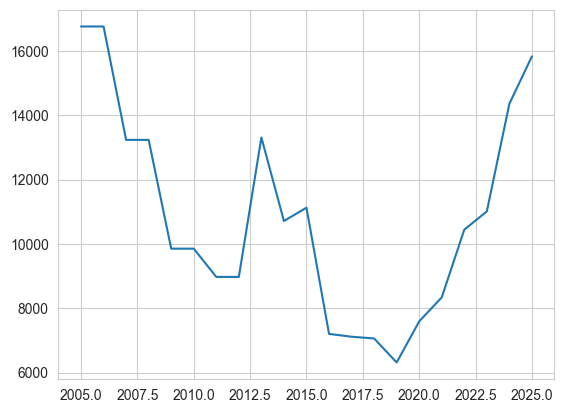

In [61]:
final['Total Cerrado Deforestation'].plot()
plt.show()

In [62]:
final = final.reset_index(names='Years')
final

,Years,Total cattle and meat exports,Total wood exports,Total soy exports,Total coffee exports,Total Cerrado Deforestation
0,2005,3.472239e+08,1.510530e+09,1.057810e+10,8.053419e+08,16763.469800
1,2006,4.021849e+08,1.485338e+09,1.023524e+10,8.820798e+08,16763.469800
2,2007,2.989044e+08,1.703562e+09,9.566551e+09,8.852683e+08,13236.536323
3,2008,1.312445e+08,1.289001e+09,8.905837e+09,9.608392e+08,13236.536323
4,2009,1.418567e+08,7.933405e+08,8.209373e+09,9.240666e+08,9854.539473
5,2010,1.576769e+08,8.392297e+08,5.382201e+09,9.832631e+08,9854.539473
6,2011,1.496994e+08,6.883544e+08,5.039373e+09,9.377824e+08,8975.341458
7,2012,1.655764e+08,5.386584e+08,4.905662e+09,7.948685e+08,8975.341458
8,2013,2.048152e+08,6.024996e+08,4.712690e+09,8.894710e+08,13311.985692
9,2014,1.685335e+08,7.284682e+08,5.840593e+09,1.054021e+09,10713.974121


In [63]:
final.to_csv('deforestation_predicted.csv')